In [1]:
import math
import random
import re

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# load the dataset but only keep the top n words, zero the rest
# 단어의 등장 빈도 순위 , 여기서는 10000 이므로 1~10000 순위의 총 10000개 단어 사용
# 빈도 횟수가 제일 많은 10000개의 단어를 학습에 이용하게 됩니다. (문장의 갯수 = 총 review의 갯수화 혼동하시면 안됩니다.)

top_words = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=top_words) #데이터로드에 정해진 parameter로서, 할당된 크기만큼 자주쓰인 단어를 불러옴

print(x_train.shape) # list가 총 25,000개 있음, 이 리뷰안에 여러 단어가 쓰였을텐데 위에서 언급한 10000개의 단어만 사용하게 됩니다.
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)  # 0과 1이 있다. 0의 경우 부정 , 1의 경우 긍정
print(x_test[0])
print(y_test[0]) #0 이 나온 것으로 미루어 부정적인 리뷰

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(25000,)
(25000,)
(25000,)
(25000,)
[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]
0


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
<class 'dict'>
88584
the
and
a
of
to
direct
[Example] lengths of 5 reviews:  [218, 189, 141, 550, 147]
The longest length of the review : 2494
The average length of the review : 238.71364


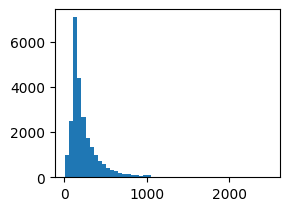

In [3]:
#data구조를 좀더 알아 보겠습니다.
word_to_index = tf.keras.datasets.imdb.get_word_index()
print(type(word_to_index))
# print(word_to_index) ## word_to_index는 dic 이며, 위 쪽 print 해보면 좀더 자세하게d dict구조를 알 수 있습니다. #key는 단어, #value는 그 단어의 빈도수 순위입니다.
print(len(word_to_index.items()))

#제일 많이 사용된 단어 몇개를 살펴보겠습니다. 먼저 key와 value를 바꾸겠습니다.
index_to_word ={}
for key, value in word_to_index.items():  ## dictionary 를 tuple들로 만들기
    index_to_word[value + 3] = key ## value+3가 단어가 사용된 순위, key가 단어입니다. +3을 해주는 이유는 0,1,2가 special로 설정되었기 때문에, 3이 제일 많이 나온 단어이기 때문입니다.

for i in range(5) :
    print(index_to_word[i + 4])  ## 제일 많이 나온 단어 5개  / 다섯번째를 불러오는게 아니라 키 값에 맞는 value를 불러오는 것임.

print(index_to_word[1504]) ## 1500번째로 잘 많이 나온 단어

#한 문장(한 데이터가)의 길이가 어느정도 되는지 알아보겠습니다.
len_result = [len(s) for s in x_train] #길이의 값을 list로 만듦
print('[Example] lengths of 5 reviews: ', len_result[:5])
print('The longest length of the review : {}'.format(np.max(len_result)))
print('The average length of the review : {}'.format(np.mean(len_result)))

plt.subplot(2,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [4]:
#구체적인 문장을 가져와보겠습니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")): #pad 패드토큰=단어 #sos 시작을 알리는 토큰 #unk 주어진 단어가 미확인이라고 하는 토큰 (이것은 데이터를 만드는 사람이 사전 작업을 통해 셋팅한 것입니다.)
    index_to_word[index]=token
print(x_train[2])
print(' '.join([index_to_word[index] for index in x_train[2]]))  #하나하나 element를 쭉 연결 시킨 것 어떤 문장인지 글로 확인해보기
print(y_train[2]) #어떤 리뷰인지 맞춰보기 0은 부정 1은 긍정

[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 2, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 2, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113]
<sos> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actu

In [5]:
# truncate and pad input sequences with .preprocessing.sequence.pad_sequences
# rnn에서 Input값의 길이 기본 rnn 에서는 Sequence의 길이가 같아야 하기 때문에 아래의 작업을 필요로 합니다.
max_len = 200  # 이 길이보다 sequence의 길이가 자르면 잘라낼 것이고, 짧다면 의미없는 값을 집어넣어 sequence의 길이를 200으로 맞추어 줍니다.
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 200)# 이 과정이 없으면 길이가 다른 문제가 생깁니다. 이것은 길이를 최대 200으로 맞춰주는 역할을 합니다.
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen= 200)

In [7]:
#tf.keras.callbacks 의 EarlyStopping / ModelCheckpoint
#keras를 활용해 early stopping을 사용하겠습니다. monitor : 관찰하는 값. mode는 기본은 auto 이곳에선 loss기 때문에 min을 사용하였습니다. patience =3 입니다.
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# 모델을 저장하는 방법입니다. ./rnn_imdb란 저장되는 경로를 말하며, 제일 좋은 값으로만 저장하였고, 그 기준은 val_accuracy가 max일 때 입니다.
mc = tf.keras.callbacks.ModelCheckpoint('./best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [8]:
rnn = tf.keras.Sequential()
rnn.add(layers.Embedding(top_words, 160)) # 100000 * 160 ,10000개의 단어가 160차원의 벡터로 임베딩 https://keras.io/ko/layers/embeddings/ This layer can only be used as the first layer in a model.
#output (배치의크기, sequence의 길이, 한 단어의 길이)
rnn.add(layers.SimpleRNN(64)) #Whh = 64*64 , Wxh = 64*160, b =64
rnn.add(layers.Dense(1, activation ='sigmoid'))# 앞의 64개에 대한 weight 64+ bias: 1
rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
rnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics =['accuracy'])
#callbacks의 기능은 위에서 정의한 early stopping 과 model_check_point를 저장한다는 의미 입니다.
result = rnn.fit(x_train, y_train, epochs =5, callbacks=[es,mc], batch_size=60, validation_split =0.2)

Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5826 - loss: 0.6578
Epoch 1: val_accuracy improved from -inf to 0.77020, saving model to ./best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5829 - loss: 0.6577 - val_accuracy: 0.7702 - val_loss: 0.4956
Epoch 2/5
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8132 - loss: 0.4244
Epoch 2: val_accuracy did not improve from 0.77020
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8133 - loss: 0.4243 - val_accuracy: 0.7246 - val_loss: 0.5393
Epoch 3/5
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8524 - loss: 0.3551
Epoch 3: val_accuracy did not improve from 0.77020
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8525 - loss: 0.3550 - val_accuracy: 0.6830 - val_loss: 0.5928
Epoch 4/5
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8496 - loss: 0.3396
Epoch 4: val_accuracy did not improve from 0.77020
334/334 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.849

In [10]:
rnn.evaluate(x_test,y_test) #위의 결과 보면 overfitting을 서서히 생각해봐야함

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7479 - loss: 0.5372


[0.5308770537376404, 0.7504799962043762]

In [12]:
loaded_model = tf.keras.models.load_model('best_model.keras')   ###위의 결과값과 아래의 결과값이 다른 이유는 학습된 모델에 저장된 weight가 다르기 때문입니다. 저장하는 모델에는 early stopping과 check point가 적용되기 때문입니다.
print((loaded_model.evaluate(x_test, y_test)))

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7811 - loss: 0.4896
[0.48817944526672363, 0.7805600166320801]


In [13]:
def sentiment_predict(new_sentence):
    # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
    new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

    # 정수 인코딩
    encoded = []
    for word in new_sentence.split():
        # 단어 집합의 크기를 10,000으로 제한.
        try :
            if word_to_index[word] <= 10000:
                encoded.append(word_to_index[word]+3)
            else:
                # 10,000 이상의 숫자는 <unk> 토큰으로 취급.
                encoded.append(2)
        # 단어 집합에 없는 단어는 <unk> 토큰으로 취급.
        except KeyError:
            encoded.append(2)

    pad_new = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("positive with the probability {:.2f}% .".format(score * 100))
    else:
        print("negative with the probability {:.2f}% ".format((1 - score) * 100))

In [14]:
#편하게 문장을 치시고 리뷰의 정확성을 비교해보세요.
My_review_1 = "hi this movie is the amazing movie I have ever seen in my life. really intersting very fun."
sentiment_predict(My_review_1)
My_review_2 = "The final scene at the movie was disgusting"
sentiment_predict(My_review_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
positive with the probability 89.53% .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
positive with the probability 54.94% .


<ipython-input-13-0be091181bb0>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측


In [15]:
lstm = tf.keras.Sequential()
lstm.add(layers.Embedding(top_words, 160)) # 차이점 확인  10,000 * 160
lstm.add(layers.LSTM(64))  # activation = tanh 기본
lstm.add(layers.Dense(2, activation ='softmax'))  # 2 = num_classes, #softmax 마지막에 했으므로 logit 이 들어간 loss를 사용하지 않습니다.
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
lstm.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics =['accuracy'])
print("Train LSTM Model With ")

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1, stratify = y_train)

#lstm = rnn.fit(x_train, y_train, epochs =10, callbacks=[mc2], batch_size=60, validation_split =0.2)
#궁금한 것 위에 Fit 에서 split = 0.2 하면 랜덤이 아니라 일정하게 쪼개지 않음. 뒤의 20% 가져옴. 따라서 반복에 좋지 않습니다.

lstm.fit(x_train, y_train, epochs=5, callbacks = [es,mc], batch_size= 60, validation_data=(x_val, y_val) )

Train LSTM Model With 
Epoch 1/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7051 - loss: 0.5558
Epoch 1: val_accuracy improved from 0.77020 to 0.86760, saving model to ./best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7053 - loss: 0.5555 - val_accuracy: 0.8676 - val_loss: 0.3286
Epoch 2/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8886 - loss: 0.2802
Epoch 2: val_accuracy improved from 0.86760 to 0.87480, saving model to ./best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8886 - loss: 0.2802 - val_accuracy: 0.8748 - val_loss: 0.3209
Epoch 3/5
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9204 - loss: 0.2024
Epoch 3: val_accuracy did not improve from 0.87480
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9204 - loss: 0.2024 - val_accuracy: 0.8674 - val_loss: 0.3732
Epoch 4/5
330/334 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9379 - loss: 0.1715
Epoch 4: val_accuracy did not improve from 0.8

In [17]:
rnn.evaluate(x_test,y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7479 - loss: 0.5372


[0.5308770537376404, 0.7504799962043762]

In [19]:
loaded_model2 = tf.keras.models.load_model('best_model.keras')
print((loaded_model2.evaluate(x_test, y_test)))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8600 - loss: 0.3539
[0.35484322905540466, 0.85971999168396]


In [20]:
multi_lstm = tf.keras.Sequential()
multi_lstm.add(layers.Embedding(top_words, 160))
multi_lstm.add(layers.LSTM(64, return_sequences = True)) ## return sequence는 매번 hideen cell 에서 ouput을 내보내고, 이것이 다음 layer의 input값으로 사용됩니다.
multi_lstm.add(layers.LSTM(64))
multi_lstm.add(layers.Dense(2, activation ='softmax'))

multi_lstm.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics =['accuracy'])
print("Train Multi_LSTM")
multi_lstm.fit(x_train, y_train, epochs = 5, callbacks = [es,mc], batch_size= 60, validation_data=(x_val, y_val) )

Train Multi_LSTM
Epoch 1/5
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6970 - loss: 0.5478
Epoch 1: val_accuracy did not improve from 0.87480
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6975 - loss: 0.5472 - val_accuracy: 0.8680 - val_loss: 0.3222
Epoch 2/5
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8913 - loss: 0.2695
Epoch 2: val_accuracy improved from 0.87480 to 0.88120, saving model to ./best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8914 - loss: 0.2694 - val_accuracy: 0.8812 - val_loss: 0.2976
Epoch 3/5
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9370 - loss: 0.1737
Epoch 3: val_accuracy did not improve from 0.88120
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9369 - loss: 0.1738 - val_accuracy: 0.8414 - val_loss: 0.3710
Epoch 4/5
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9432 - loss: 0.1562
Epoch 4: val_accuracy did not improve from 0.88120
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/st

In [21]:
loaded_model = tf.keras.models.load_model('best_model.keras')
print((loaded_model.evaluate(x_test, y_test)))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8656 - loss: 0.3229
[0.32661762833595276, 0.8633999824523926]
